In [2]:
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.dataset as ds
import pyarrow.compute as pc
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
from multiprocessing import Pool
import json
from source import *
import matplotlib.pyplot as plt
import pyarrow.parquet as pq

import scienceplots

plt.style.use(['science','ieee', 'grid'])

In [4]:
decay_mod_tau = ["$e^+ \\nu_e \\bar \\nu_\\tau$", "$\mu^+ \\nu_\\mu \\bar \\nu_\\tau$", "$\\pi^+ \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\pi^0) \\bar \\nu_\\tau$", "$\\pi^+ \\pi^+ \\pi^- \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\gamma) \\bar \\nu_\\tau$"]
mask = (pc.field("E_gamma_in_ROE") < 1.2) & (pc.field("Bs_lik") > 0.0012) 
mask_M = (pc.field("M0") > 5.347) &  (pc.field("M0") < 5.387) 
mask1 = (pc.field("E_gamma_in_ROE") < 1.2) & (pc.field("is0") == 1) & (pc.field("Bs_lik") > 0.0012) &  (pc.field("M0") > 5.347) &  (pc.field("M0") < 5.387) 
mask0 = (pc.field("E_gamma_in_ROE") < 1.2) & (pc.field("is0") == 0) & (pc.field("Bs_lik") > 0.0012) &  (pc.field("M0") > 5.347) &  (pc.field("M0") < 5.387)
mask_is1 = pc.field("correct_nu_0") & pc.field("correct_nu_1") & pc.field("correct_gamma_0") & pc.field("correct_gamma_1") & pc.field("lost_0") & pc.field("lost_1") & pc.field("Miss_id_0") & pc.field("Miss_id_1")
mask_is0 = pc.field("is0") == 1
mask_lep = ((pc.field("idec0") == 0) | (pc.field("idec0") == 1)) & ((pc.field("idec1") == 0) | (pc.field("idec1") == 1))

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_6657/511305829.py:1: SyntaxWarning: invalid escape sequence '\m'
  decay_mod_tau = ["$e^+ \\nu_e \\bar \\nu_\\tau$", "$\mu^+ \\nu_\\mu \\bar \\nu_\\tau$", "$\\pi^+ \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\pi^0) \\bar \\nu_\\tau$", "$\\pi^+ \\pi^+ \\pi^- \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\gamma) \\bar \\nu_\\tau$"]


In [ ]:
dataset = ds.dataset("gen_data/ubs_charm.parquet", format="parquet")

In [3]:
scanner = dataset.scanner(batch_size=100_000)
for batch in scanner.to_batches():
    table = pa.Table.from_batches([batch])
    display(table.to_pandas().columns)
    break
del scanner

Index(['__experiment__', '__run__', '__event__', '__production__',
       '__candidate__', '__ncandidates__', '__weight__', 'N_KL', 'idec0',
       'idec1', 'totalEnergyMC', 'E_gamma_in_ROE', 'Bs_lik', 'is0',
       'Miss_id_0', 'Miss_id_1', 'missedE', 'M0', 'p0', 'recM2', 'p_tau_0',
       'p_tau_1', 'tau_d_0_0', 'tau_d_1_0', 'tau_last_z_0', 'tau_last_r_0',
       'tau_last_z_1', 'tau_last_r_1', 'correct_nu_0', 'correct_nu_1',
       'correct_gamma_0', 'correct_gamma_1', 'lost_0', 'lost_1',
       'PID_self_vs_0_tau0', 'PID_self_vs_1_tau0', 'PID_self_vs_2_tau0',
       'PID_self_vs_4_tau0', 'PID_self_vs_0_tau1', 'PID_self_vs_1_tau1',
       'PID_self_vs_2_tau1', 'PID_self_vs_4_tau1'],
      dtype='object')

In [18]:
wbin = 0.05
a = 0
b = 1.2
bins = np.linspace(a, b, int((b-a)/wbin))

/tmp/ipykernel_49623/3386446398.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


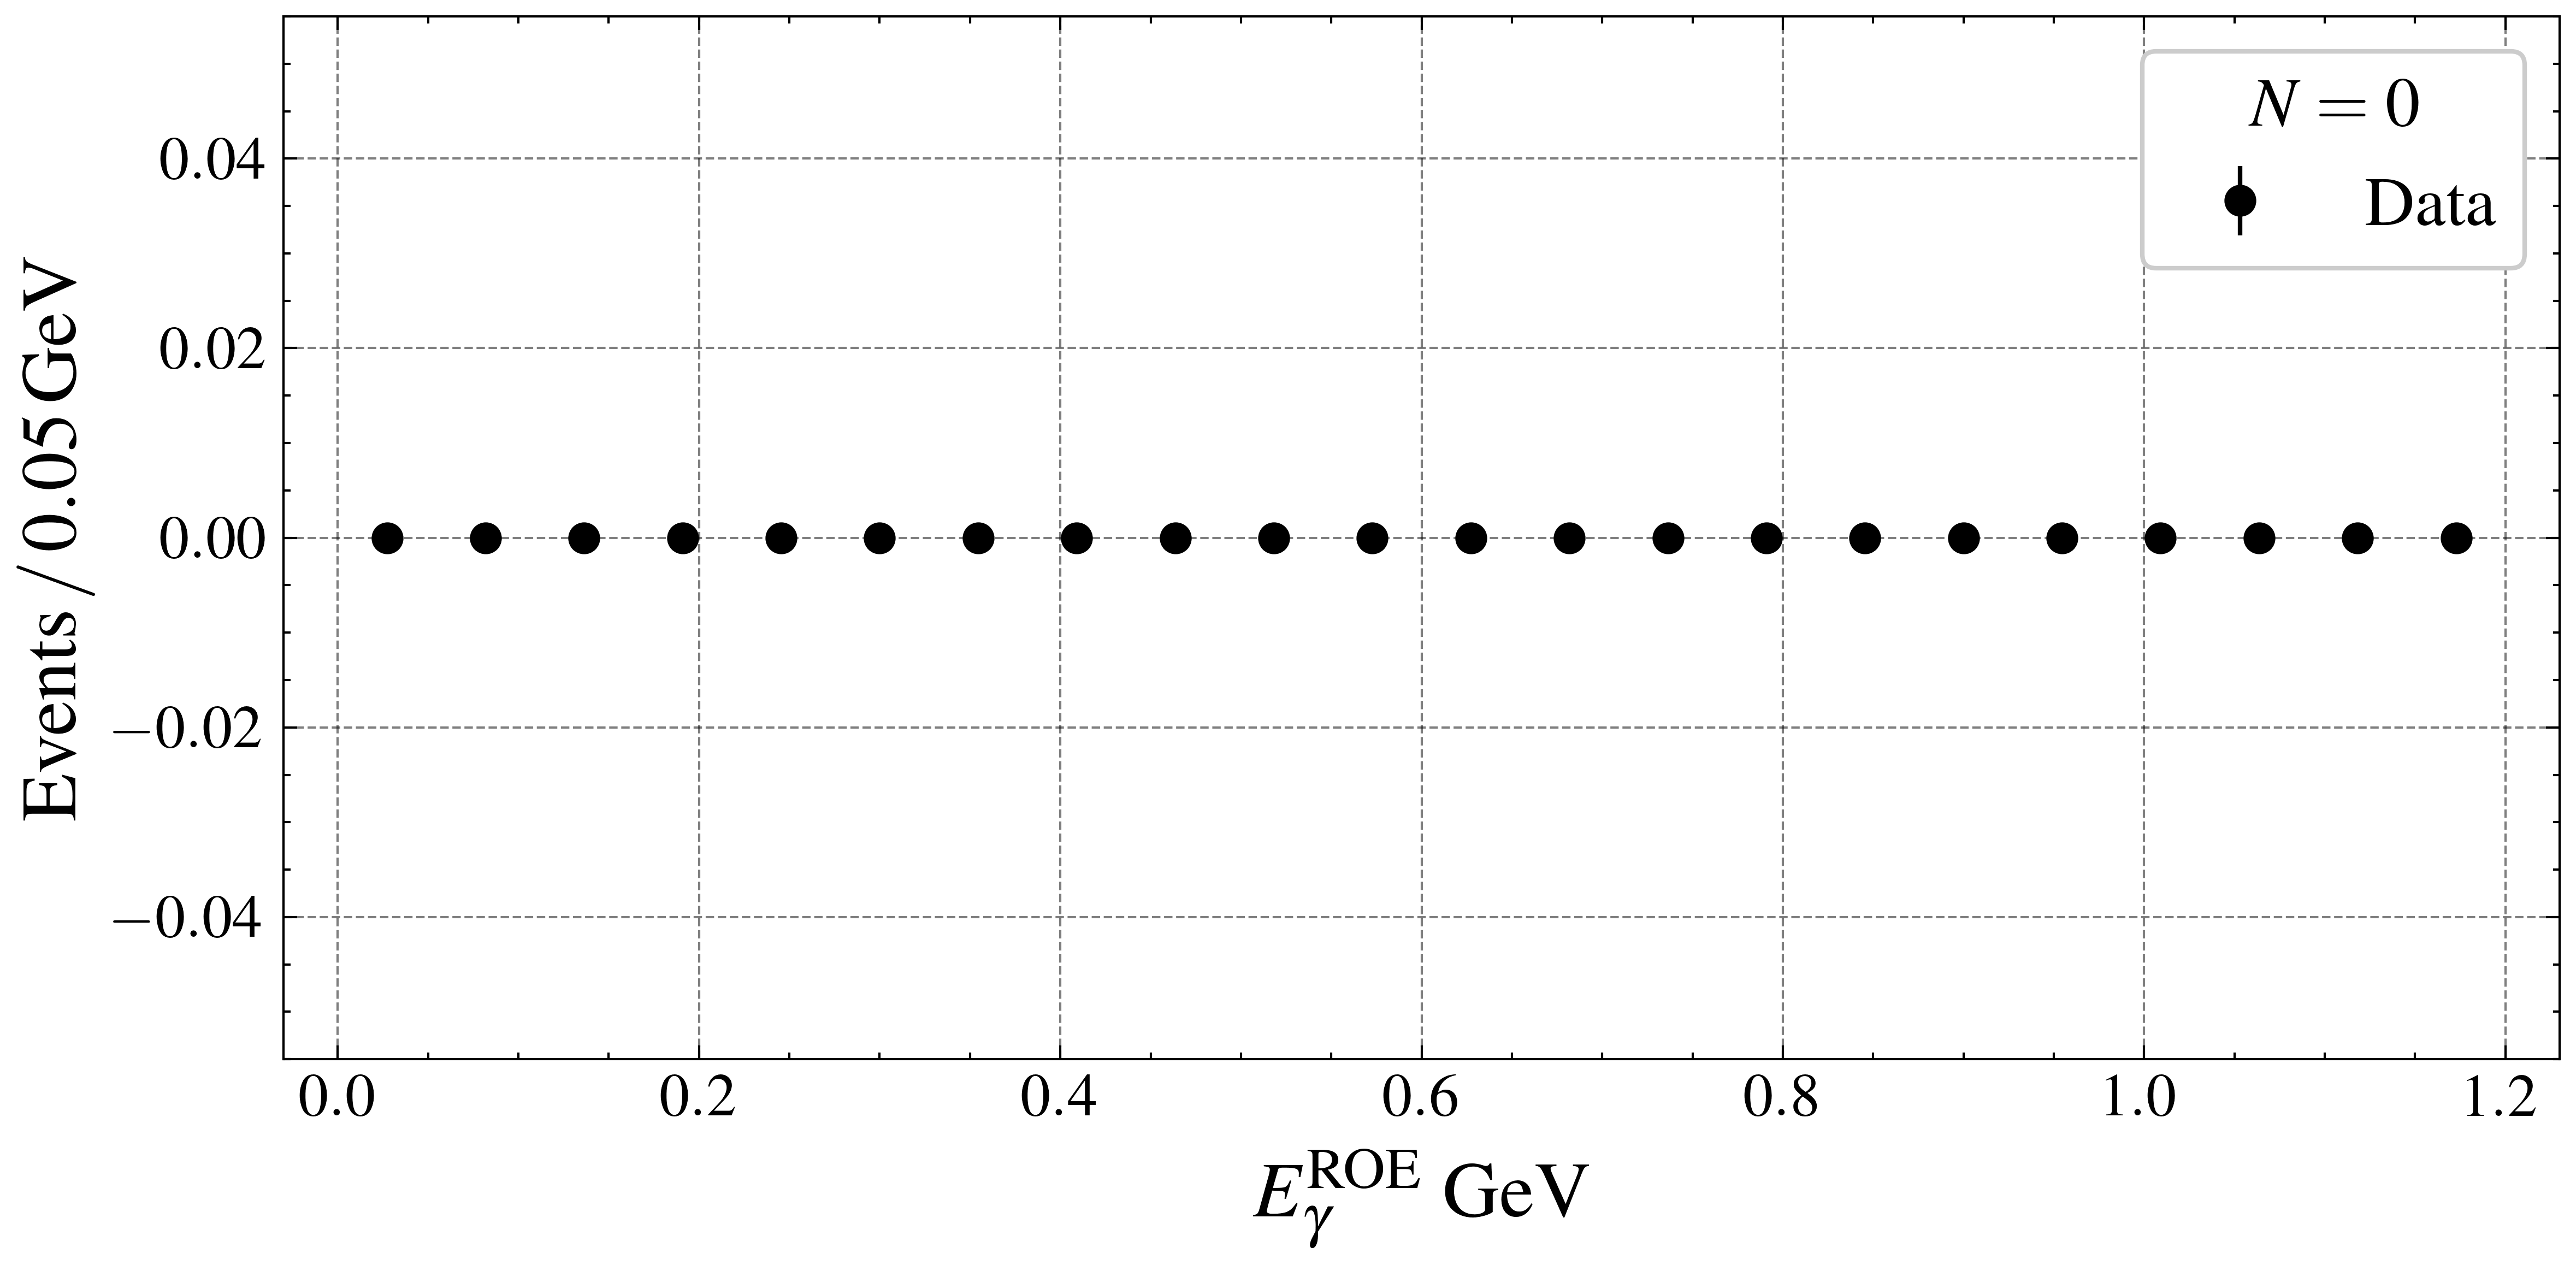

In [21]:
bin_centers, counts, N = compute_histogram(dataset, bins, "E_gamma_in_ROE", filter_mask= mask & mask_lep)


fig, ax = plt.subplots(1, figsize=(12/1.5, 6/1.5))

ax.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='o', label="Data")
ax.set_ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}\\,\\mathrm{{GeV}}$')
ax.set_xlabel(r'$E_{\gamma}^\mathrm{ROE} \ \mathrm{GeV}$')
ax.set_title("")
ax.legend(title=f"$N = {N}$")

plt.tight_layout()
plt.show()

In [23]:
dataset = ds.dataset("gen_data/nonbsbs.parquet", format="parquet")

In [24]:
scanner = dataset.scanner(batch_size=100_000)
for batch in scanner.to_batches():
    table = pa.Table.from_batches([batch])
    display(table.to_pandas().columns)
    break
del scanner

Index(['__experiment__', '__run__', '__event__', '__production__',
       '__candidate__', '__ncandidates__', '__weight__', 'N_KL', 'idec0',
       'idec1', 'totalEnergyMC', 'E_gamma_in_ROE', 'Bs_lik', 'is0',
       'Miss_id_0', 'Miss_id_1', 'missedE', 'M0', 'p0', 'recM2', 'p_tau_0',
       'p_tau_1', 'tau_d_0_0', 'tau_d_1_0', 'tau_last_z_0', 'tau_last_r_0',
       'tau_last_z_1', 'tau_last_r_1', 'correct_nu_0', 'correct_nu_1',
       'correct_gamma_0', 'correct_gamma_1', 'lost_0', 'lost_1',
       'PID_self_vs_0_tau0', 'PID_self_vs_1_tau0', 'PID_self_vs_2_tau0',
       'PID_self_vs_4_tau0', 'PID_self_vs_0_tau1', 'PID_self_vs_1_tau1',
       'PID_self_vs_2_tau1', 'PID_self_vs_4_tau1'],
      dtype='object')

In [26]:
wbin = 0.05
a = 0
b = 1.2
bins = np.linspace(a, b, int((b-a)/wbin))

/tmp/ipykernel_49623/3386446398.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


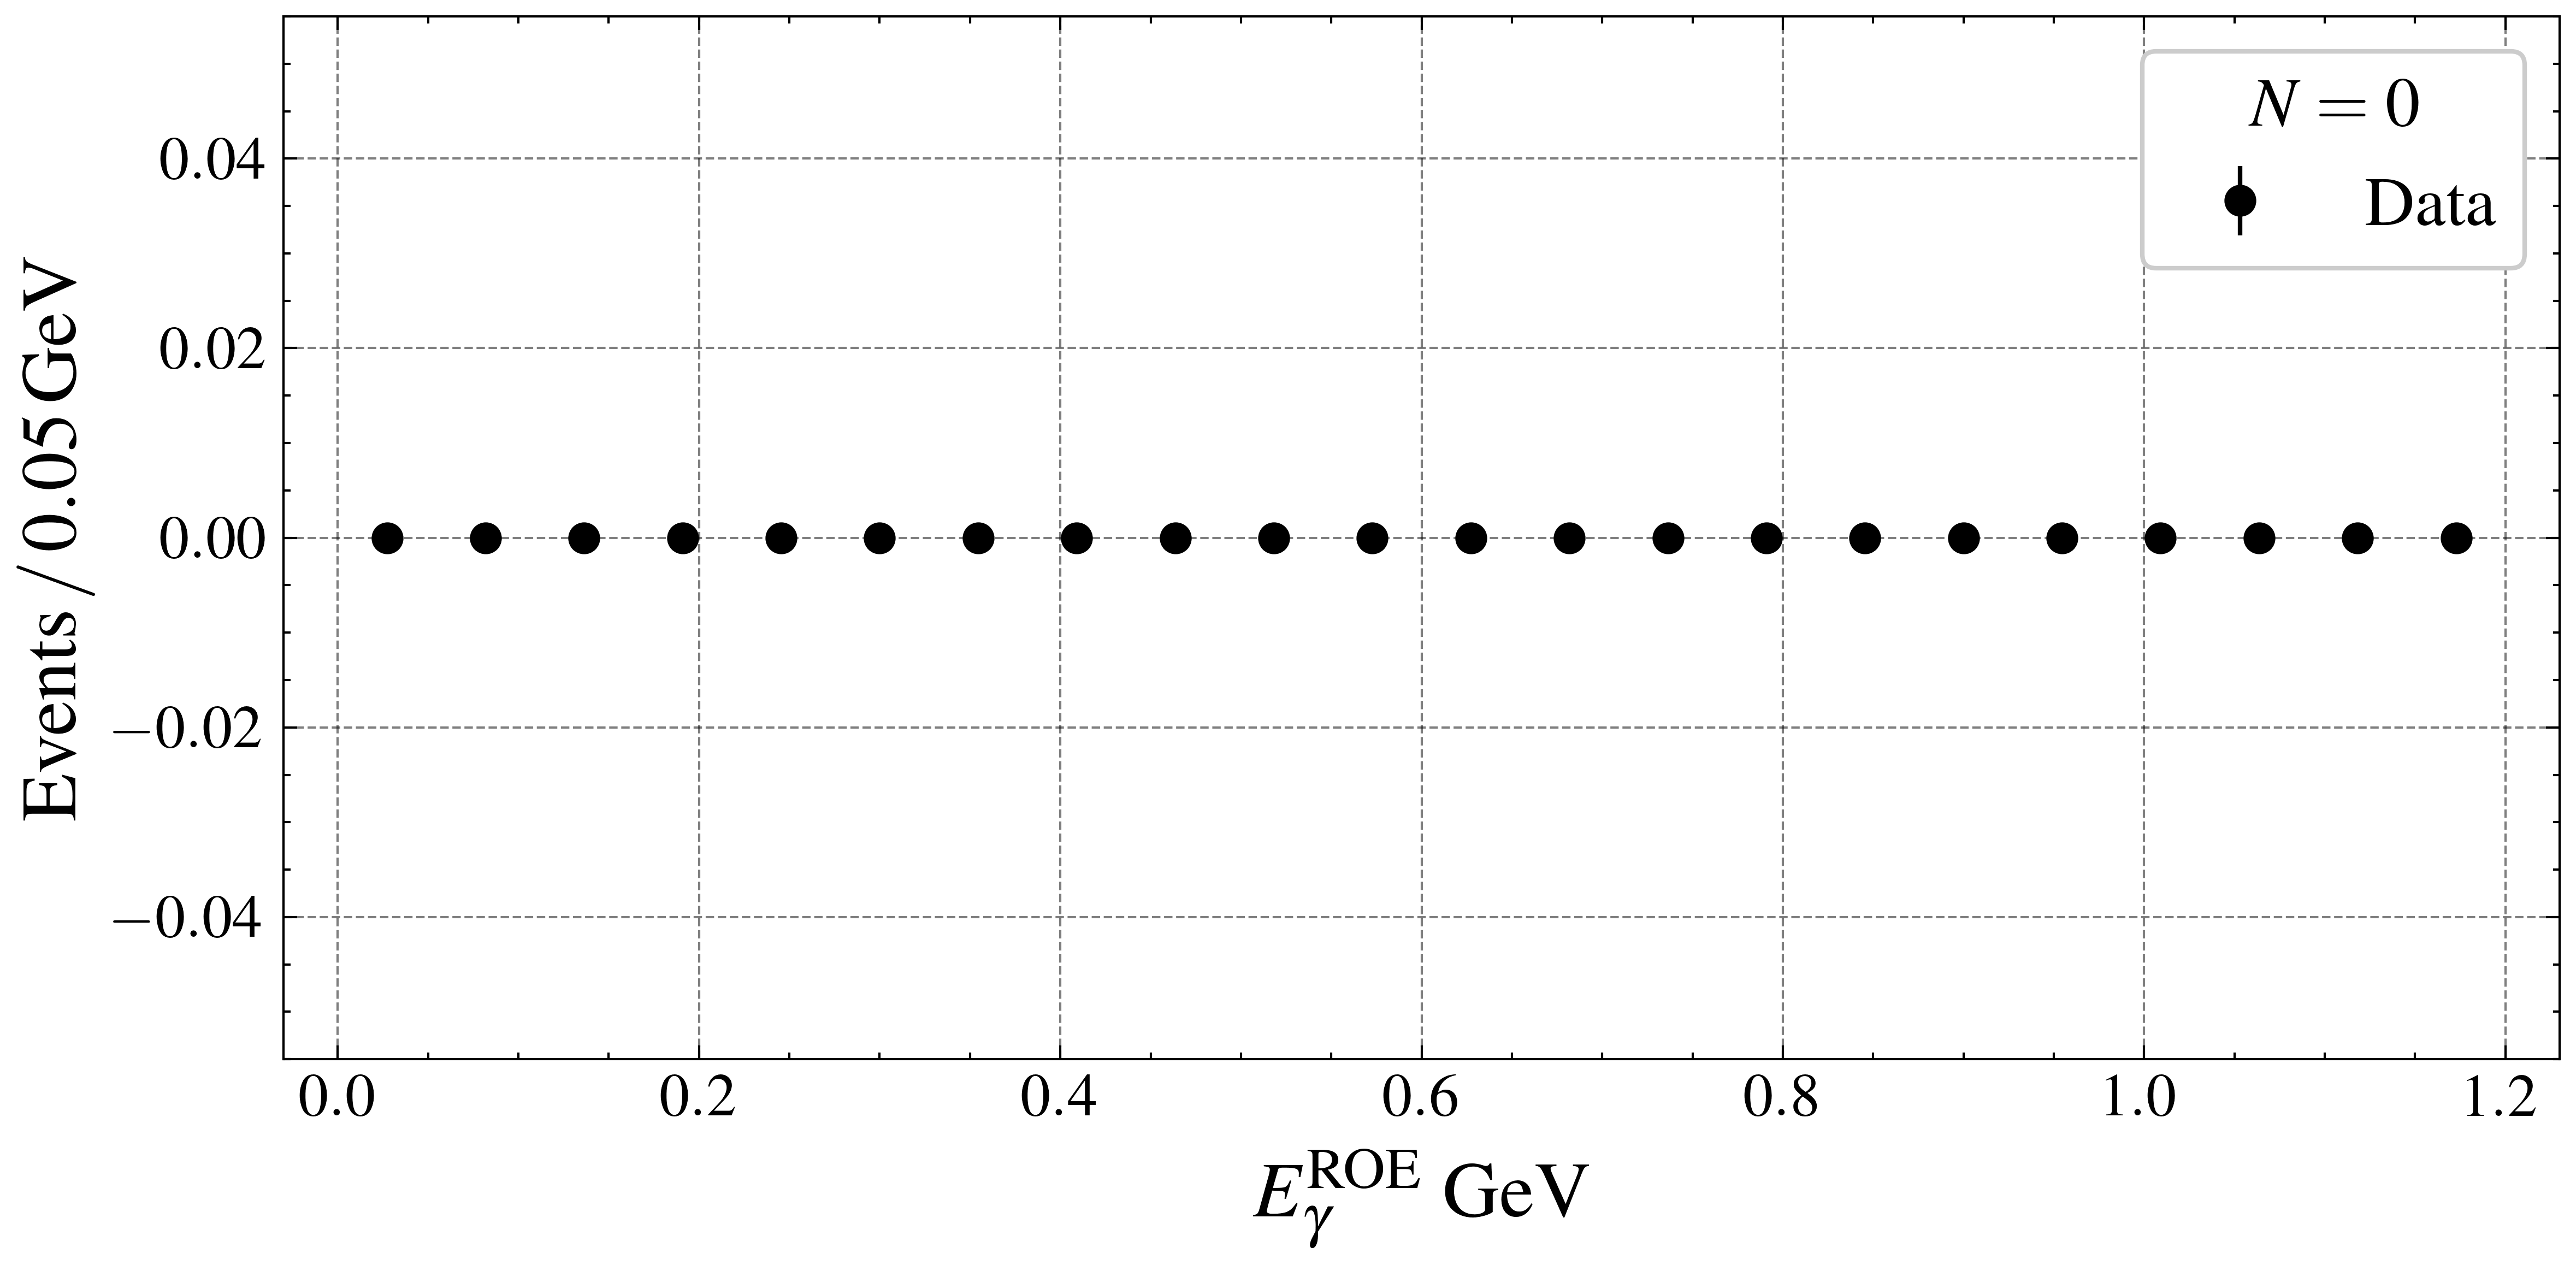

In [29]:
bin_centers, counts, N = compute_histogram(dataset, bins, "E_gamma_in_ROE", filter_mask= mask & mask_lep)


fig, ax = plt.subplots(1, figsize=(12/1.5, 6/1.5))

ax.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='o', label="Data")
ax.set_ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}\\,\\mathrm{{GeV}}$')
ax.set_xlabel(r'$E_{\gamma}^\mathrm{ROE} \ \mathrm{GeV}$')
ax.set_title("")
ax.legend(title=f"$N = {N}$")

plt.tight_layout()
plt.show()

In [5]:
dataset = ds.dataset("gen_data/bsbs.parquet", format="parquet")

In [6]:
scanner = dataset.scanner(batch_size=100_000)
for batch in scanner.to_batches():
    table = pa.Table.from_batches([batch])
    display(table.to_pandas().columns)
    break
del scanner

Index(['__experiment__', '__run__', '__event__', '__production__',
       '__candidate__', '__ncandidates__', '__weight__', 'N_KL', 'idec0',
       'idec1', 'totalEnergyMC', 'E_gamma_in_ROE', 'Bs_lik', 'is0',
       'Miss_id_0', 'Miss_id_1', 'missedE', 'M0', 'p0', 'recM2', 'p_tau_0',
       'p_tau_1', 'tau_d_0_0', 'tau_d_1_0', 'tau_last_z_0', 'tau_last_r_0',
       'tau_last_z_1', 'tau_last_r_1', 'correct_nu_0', 'correct_nu_1',
       'correct_gamma_0', 'correct_gamma_1', 'lost_0', 'lost_1',
       'PID_self_vs_0_tau0', 'PID_self_vs_1_tau0', 'PID_self_vs_2_tau0',
       'PID_self_vs_4_tau0', 'PID_self_vs_0_tau1', 'PID_self_vs_1_tau1',
       'PID_self_vs_2_tau1', 'PID_self_vs_4_tau1'],
      dtype='object')

In [7]:
wbin = 0.05
a = 0
b = 1.2
bins = np.linspace(a, b, int((b-a)/wbin))

/tmp/ipykernel_6657/3386446398.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


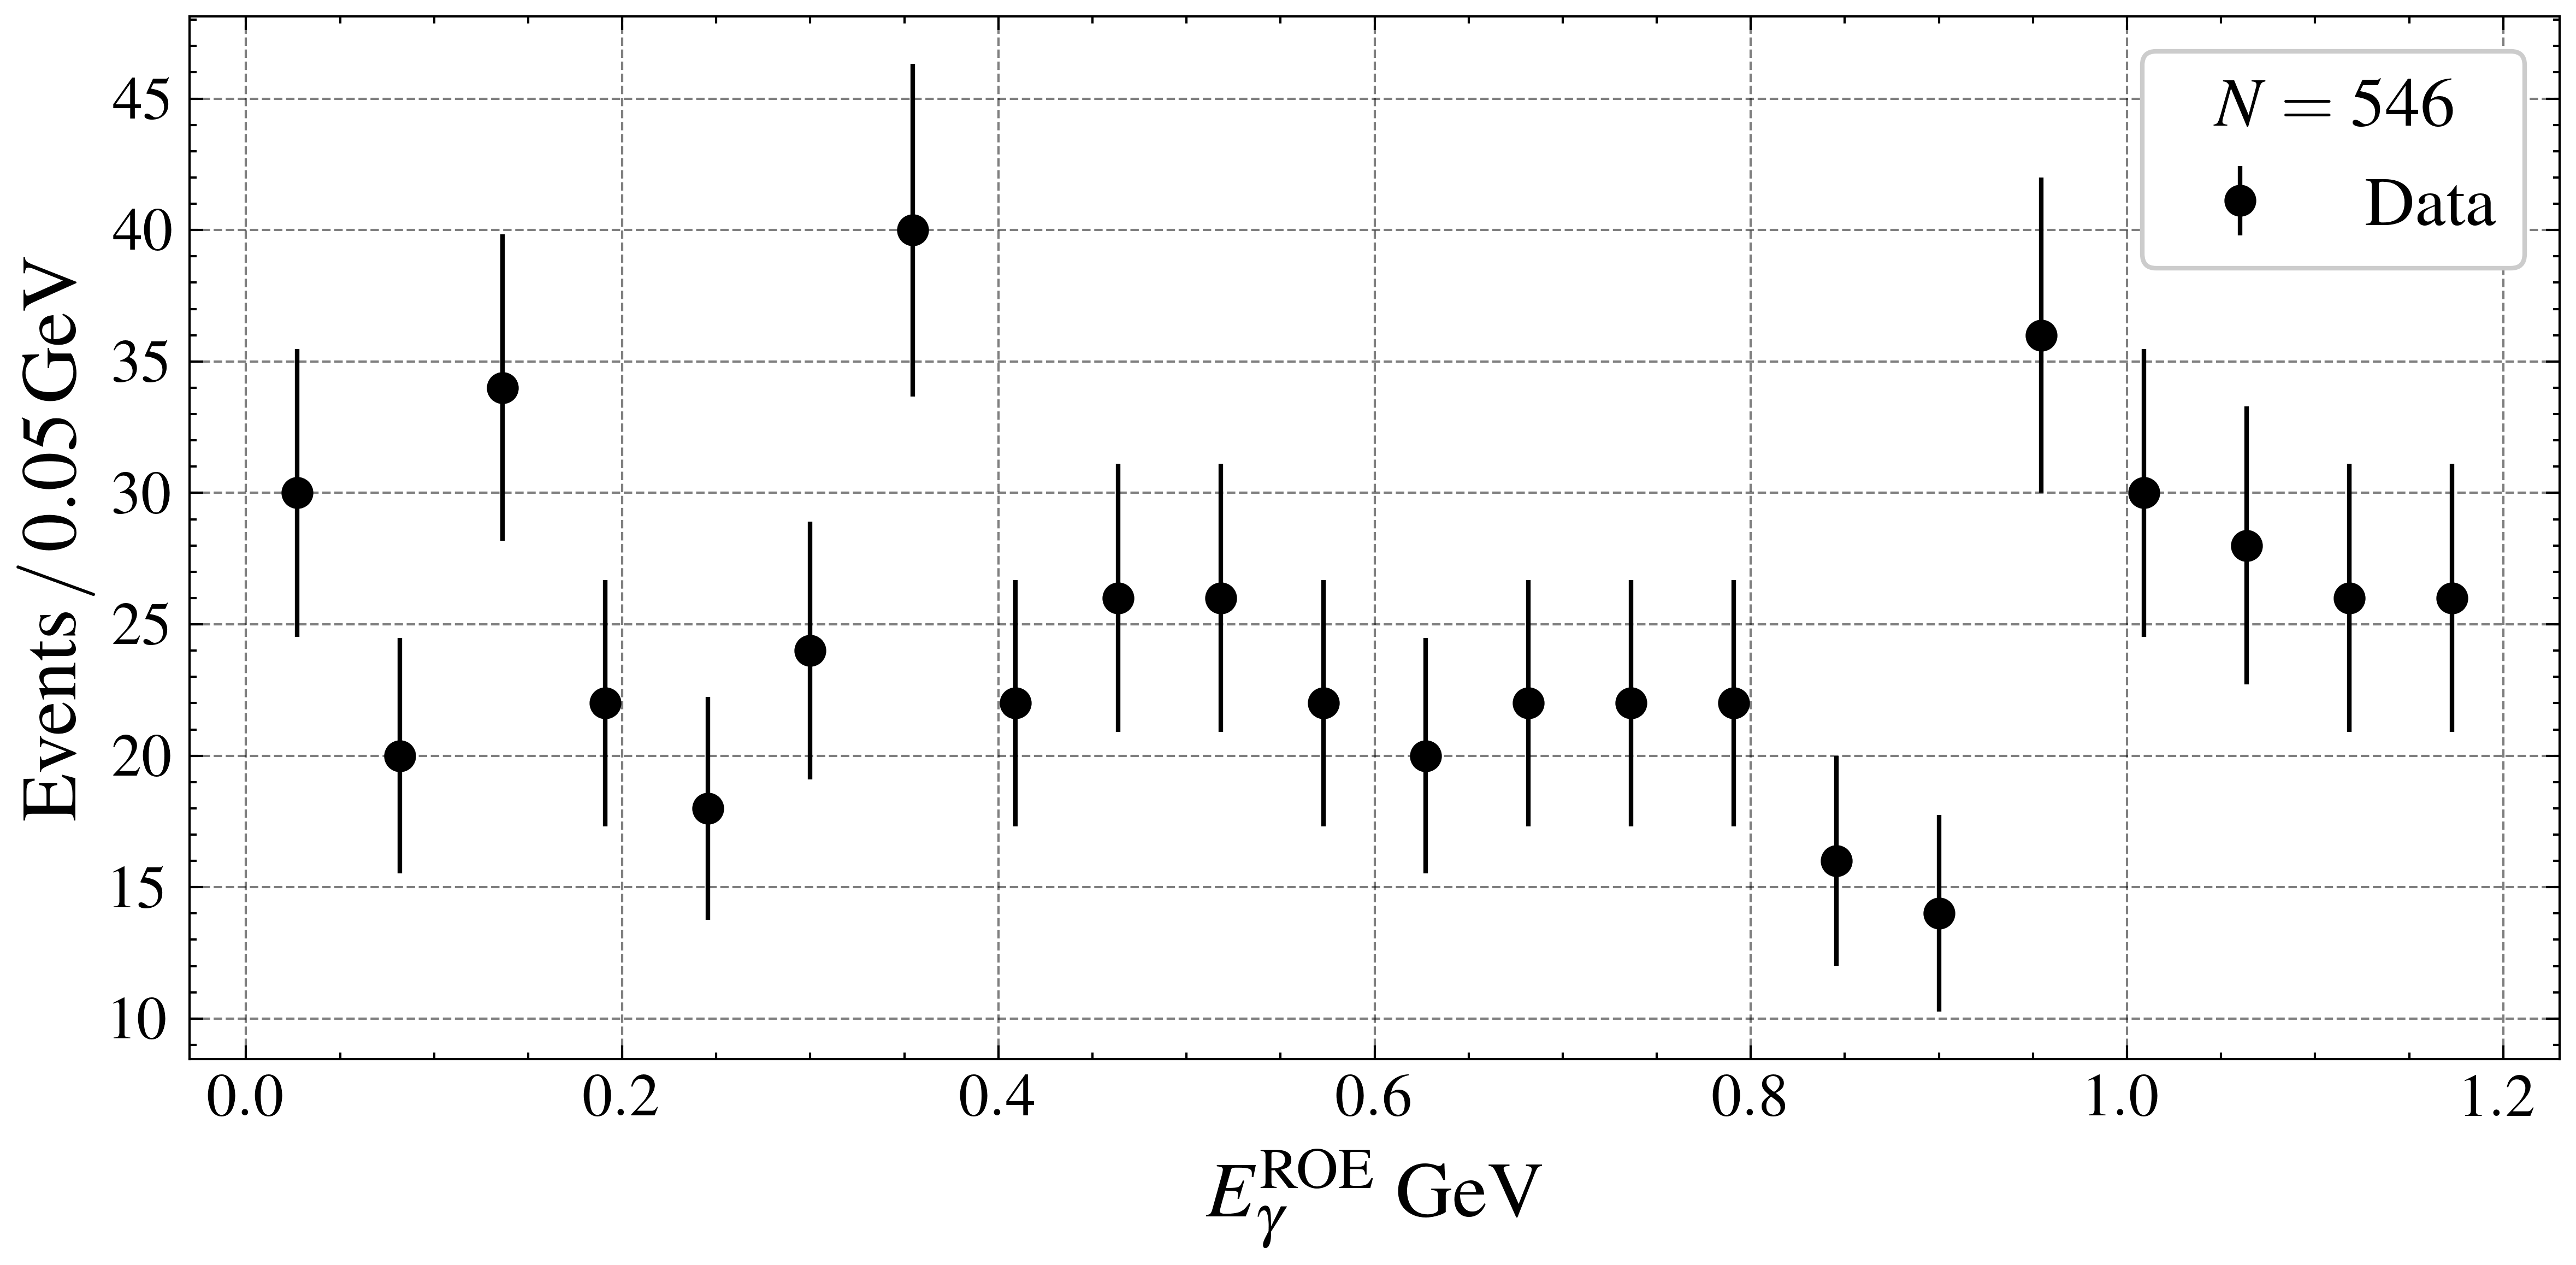

In [8]:
bin_centers, counts, N = compute_histogram(dataset, bins, "E_gamma_in_ROE", filter_mask= mask & mask_lep)


fig, ax = plt.subplots(1, figsize=(12/1.5, 6/1.5))

ax.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='o', label="Data")
ax.set_ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}\\,\\mathrm{{GeV}}$')
ax.set_xlabel(r'$E_{\gamma}^\mathrm{ROE} \ \mathrm{GeV}$')
ax.set_title("")
ax.legend(title=f"$N = {N}$")

plt.tight_layout()
plt.show()

In [9]:
wbin = 0.005
a = Bs_m - 0.1
b = Bs_m + 0.1
bins = np.linspace(a, b, int((b-a)/wbin))

/tmp/ipykernel_6657/2155535408.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


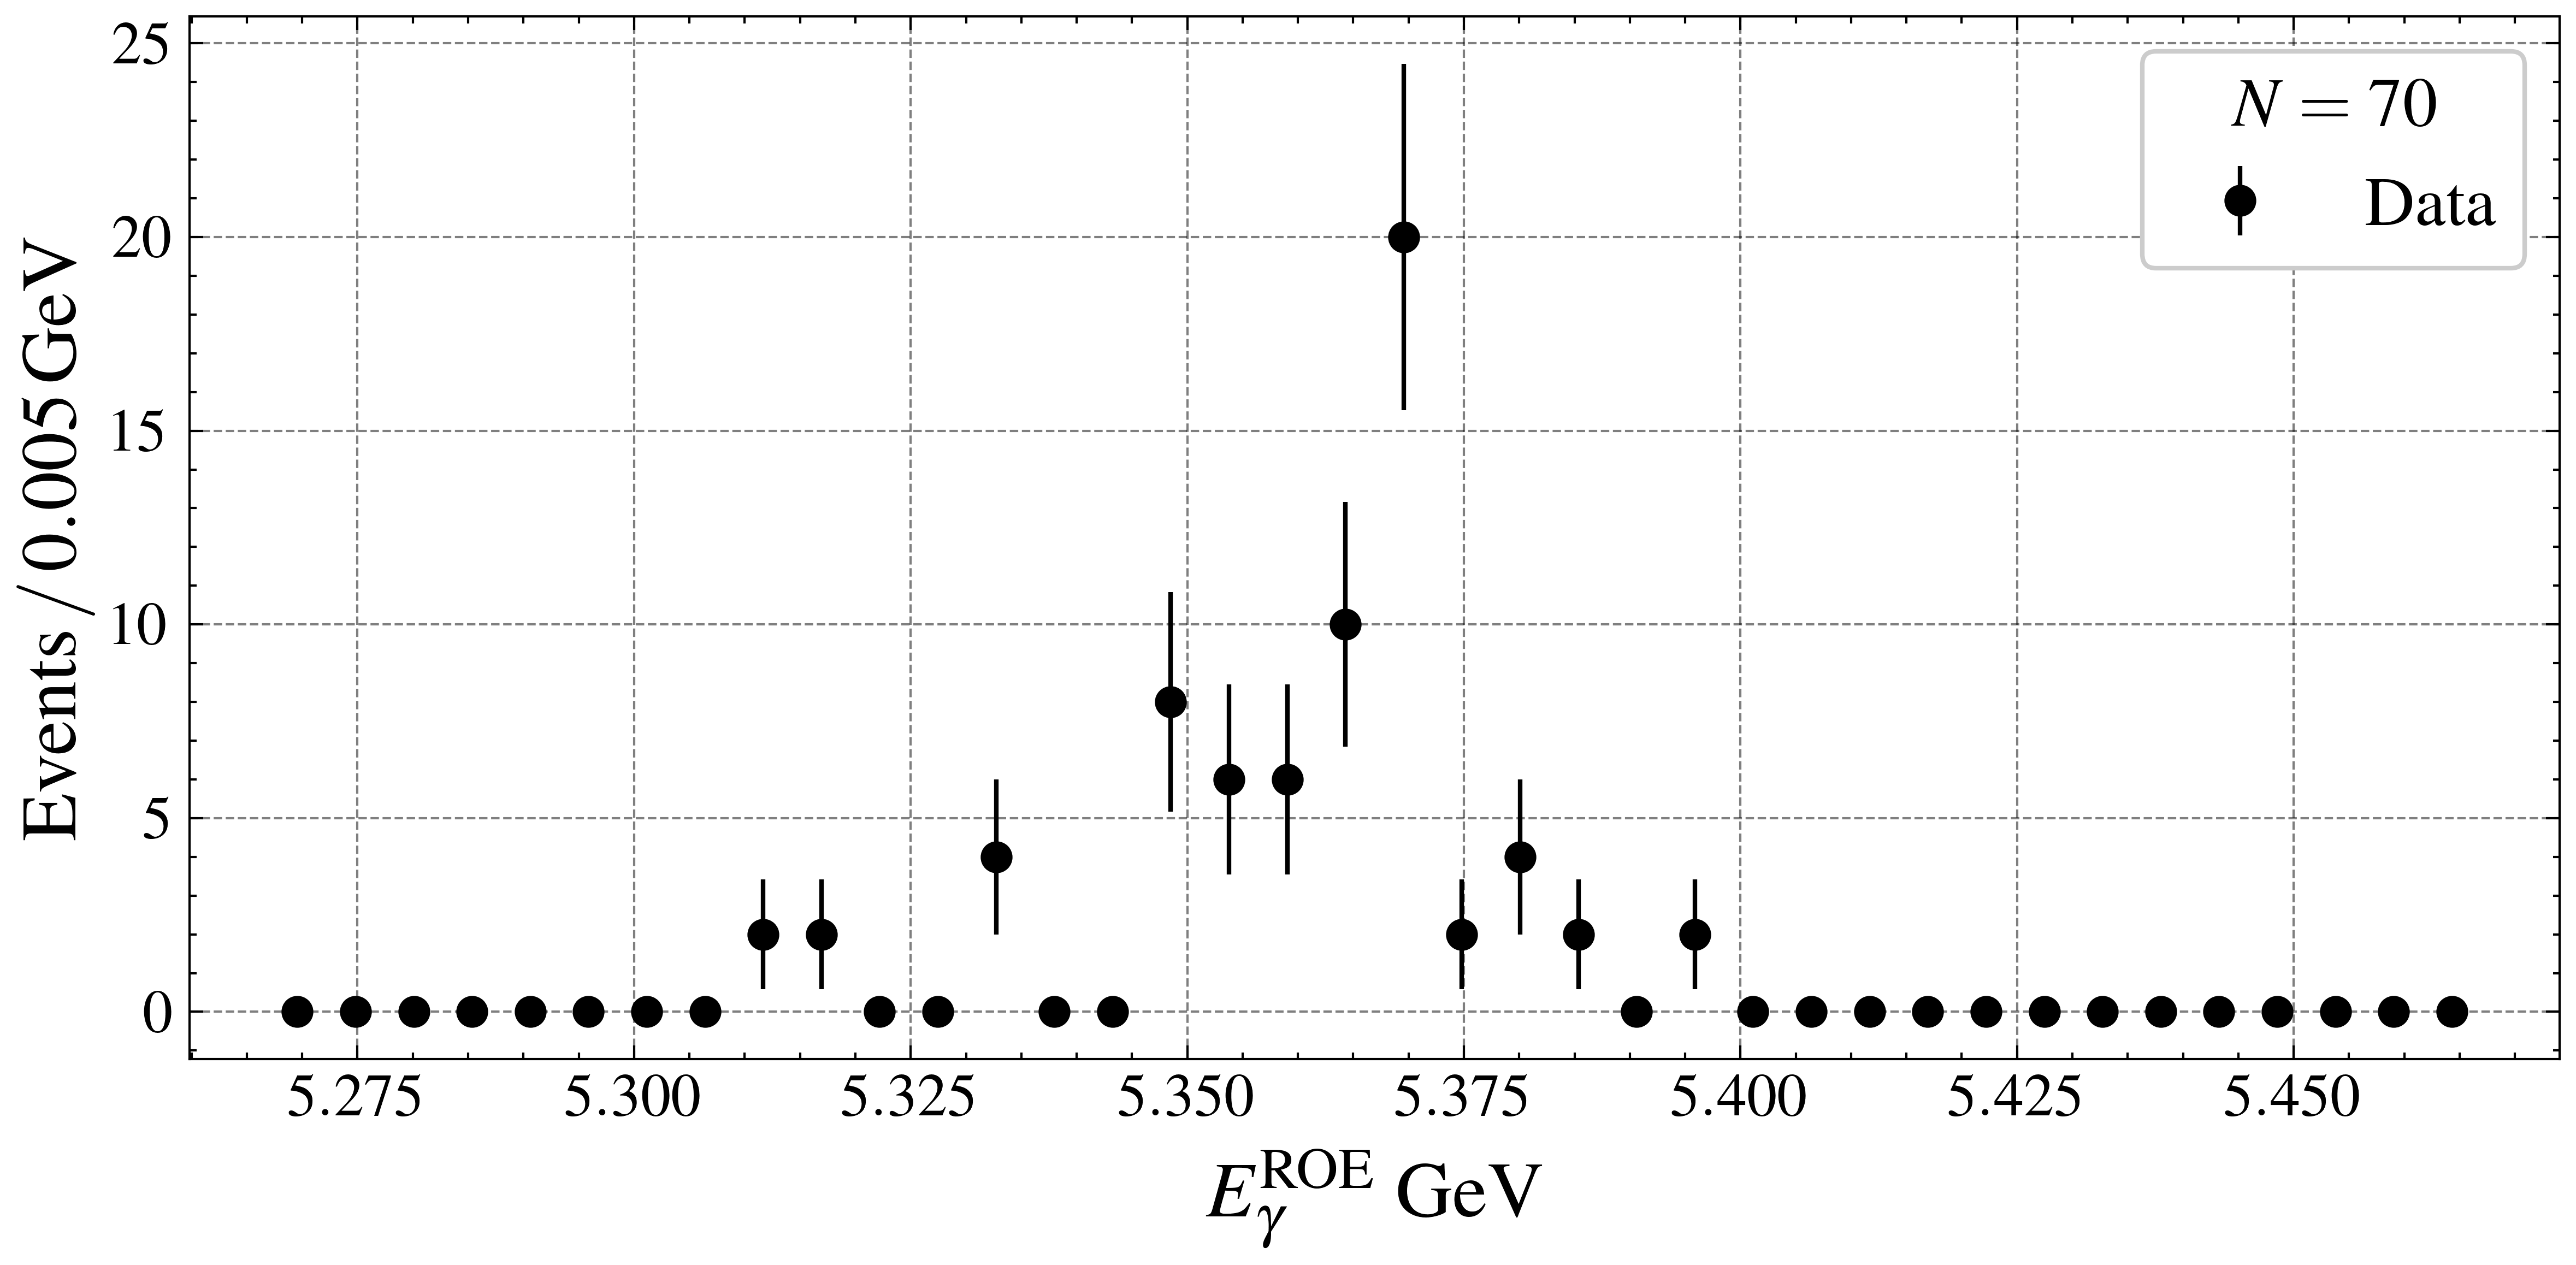

In [10]:
bin_centers, counts, N = compute_histogram(dataset, bins, "M0", filter_mask= mask & ((pc.field("E_gamma_in_ROE") < 0.2)) & mask_lep & (pc.field("is0") == 1))


fig, ax = plt.subplots(1, figsize=(12/1.5, 6/1.5))

ax.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='o', label="Data")
ax.set_ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}\\,\\mathrm{{GeV}}$')
ax.set_xlabel(r'$E_{\gamma}^\mathrm{ROE} \ \mathrm{GeV}$')
ax.set_title("")
ax.legend(title=f"$N = {N}$")

plt.tight_layout()
plt.show()

In [11]:
wbin = 0.5
a = 0
b = 10
bins = np.linspace(a, b, int((b-a)/wbin))

/tmp/ipykernel_49623/3114243305.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


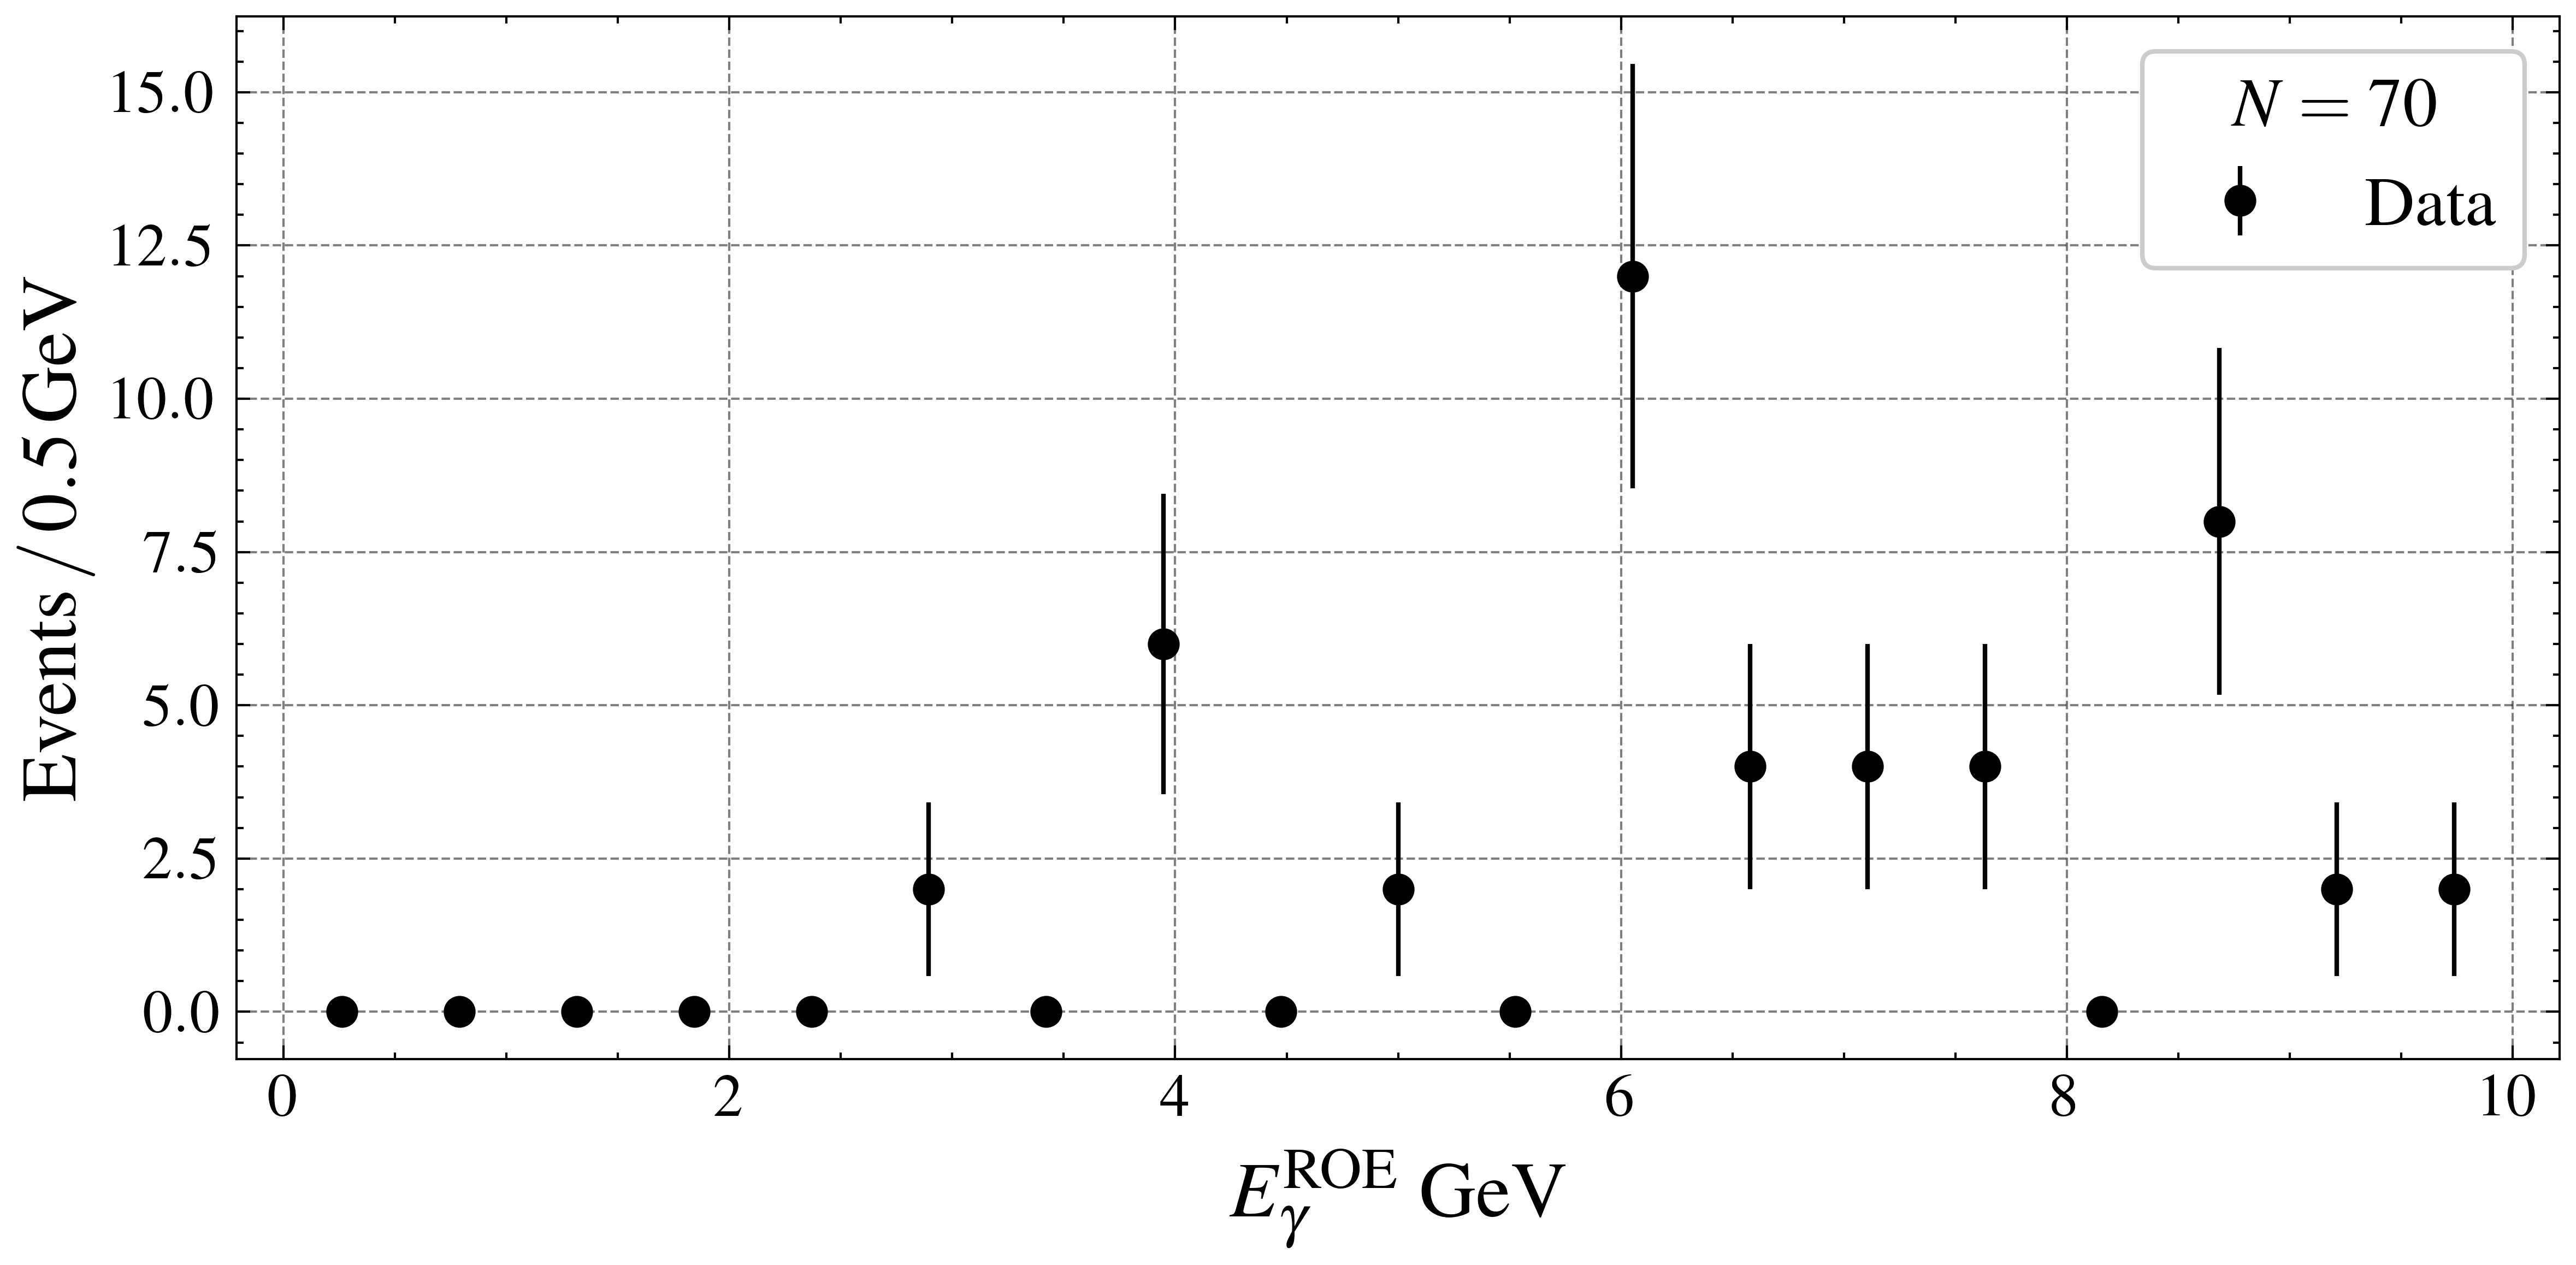

In [71]:
bin_centers, counts, N = compute_histogram(dataset, bins, "recM2", filter_mask = mask & ((pc.field("E_gamma_in_ROE") < 0.2)) & mask_lep & (pc.field("is0") == 1))


fig, ax = plt.subplots(1, figsize=(12/1.5, 6/1.5))

ax.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='o', label="Data")
ax.set_ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}\\,\\mathrm{{GeV}}$')
ax.set_xlabel(r'$E_{\gamma}^\mathrm{ROE} \ \mathrm{GeV}$')
ax.set_title("")
ax.legend(title=f"$N = {N}$")

plt.tight_layout()
plt.show()

In [12]:
wbin = 0.5
a = 0
b = 10
bins = np.linspace(a, b, int((b-a)/wbin))

/tmp/ipykernel_6657/2901583845.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


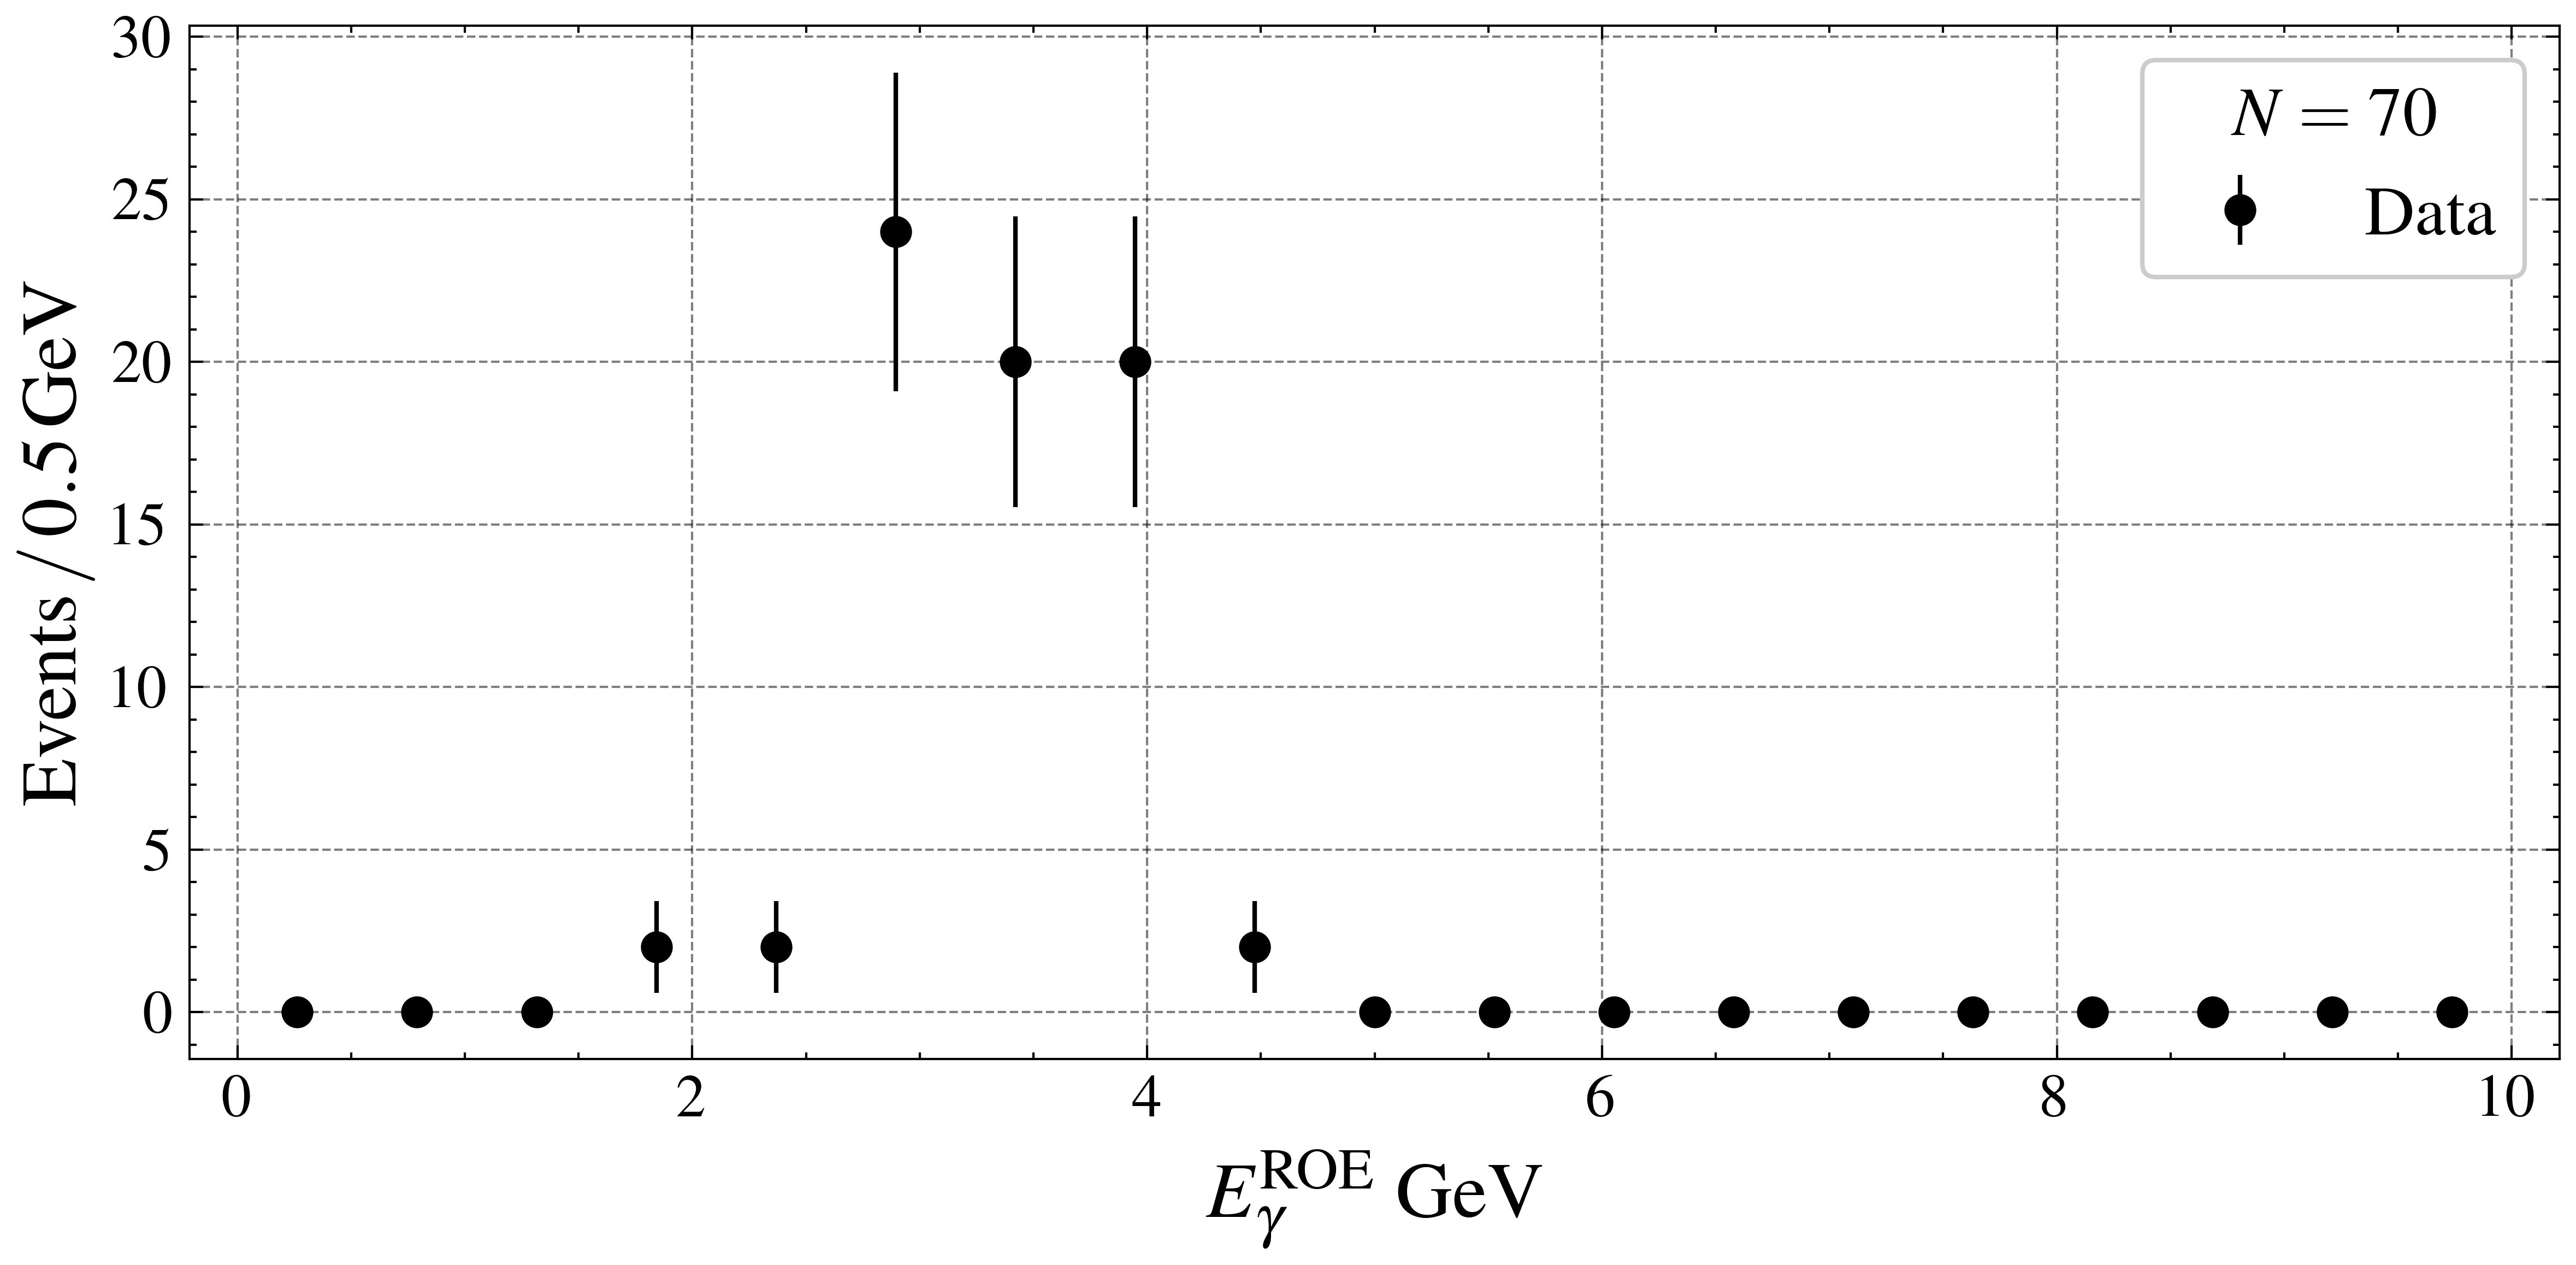

In [13]:
bin_centers, counts, N = compute_histogram(dataset, bins, "missedE", filter_mask = mask & ((pc.field("E_gamma_in_ROE") < 0.2)) & mask_lep & (pc.field("is0") == 1))


fig, ax = plt.subplots(1, figsize=(12/1.5, 6/1.5))

ax.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='o', label="Data")
ax.set_ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}\\,\\mathrm{{GeV}}$')
ax.set_xlabel(r'$E_{\gamma}^\mathrm{ROE} \ \mathrm{GeV}$')
ax.set_title("")
ax.legend(title=f"$N = {N}$")

plt.tight_layout()
plt.show()